In [40]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm #to check  progress bar
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor as rf_sk
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import pyspark
from pyspark.ml.regression import RandomForestRegressor as rf_sp
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [39]:
!pip install xgboost

In [35]:
path = 'C:\\Users\Test\Downloads\SQL_Dataset'

In [36]:
full_path_list = [ path + '/' + f for \
                 f in os.listdir(path) if os.path.isfile(os.path.join(path,f)) ]
full_path_list

['C:\\Users\\Test\\Downloads\\SQL_Dataset/dailyActivity_merged.csv',
 'C:\\Users\\Test\\Downloads\\SQL_Dataset/dailyCalories_merged.csv',
 'C:\\Users\\Test\\Downloads\\SQL_Dataset/dailyIntensities_merged.csv',
 'C:\\Users\\Test\\Downloads\\SQL_Dataset/dailySteps_merged.csv',
 'C:\\Users\\Test\\Downloads\\SQL_Dataset/sleepDay_merged.csv',
 'C:\\Users\\Test\\Downloads\\SQL_Dataset/weightLogInfo_merged.csv']

In [37]:
con = sql.connect("fitbit.db")
cur = con.cursor()

def get_table_name(full_path_list, i):
    return full_path_list[i].split("/")[-1].split('.')[0]

pbar = tqdm(total=len(full_path_list), desc='[Loading Data...]')
for i in range(0,len(full_path_list)):
    pd.read_csv(full_path_list[i]).to_sql(get_table_name(full_path_list, i), con, if_exists='append', index=False)
    pbar.update(1)
pbar.close()

[Loading Data...]: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 48.18it/s]


In [38]:
# simple sql query test
df = pd.read_sql(f'SELECT * FROM {get_table_name(full_path_list, 0)}', con)

df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [41]:
# check for sample data and data size
weightLogInfo_df = pd.read_sql(f'SELECT * FROM weightLogInfo_merged', con)
print(len(weightLogInfo_df))
weightLogInfo_df.head()

67


,Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,1503960366,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.650000,1,1462233599000
1,1503960366,5/3/2016 11:59:59 PM,52.599998,115.963147,NaN,22.650000,1,1462319999000
2,1927972279,4/13/2016 1:08:52 AM,133.500000,294.317120,NaN,47.540001,0,1460509732000
3,2873212765,4/21/2016 11:59:59 PM,56.700001,125.002104,NaN,21.450001,1,1461283199000
4,2873212765,5/12/2016 11:59:59 PM,57.299999,126.324875,NaN,21.690001,1,1463097599000


In [43]:
join_query = """
SELECT 
	A.Id,
	A.ActivityDate,
	A.SedentaryMinutes,
    A.Calories,
    A.TotalSteps,
	S.TotalMinutesAsleep,
    S.TotalTimeInBed
FROM 
	dailyActivity_merged A
INNER JOIN sleepDay_merged S
ON 
	A.Id = S.Id AND
    A.ActivityDate = S.SleepDay;
"""

fitbit_df = pd.read_sql(join_query, con)

print(len(fitbit_df))

0


Index(['Id', 'ActivityDate', 'SedentaryMinutes', 'TotalSteps', 'Calories',
       'TotalMinutesAsleep', 'TotalTimeInBed'],
      dtype='object')


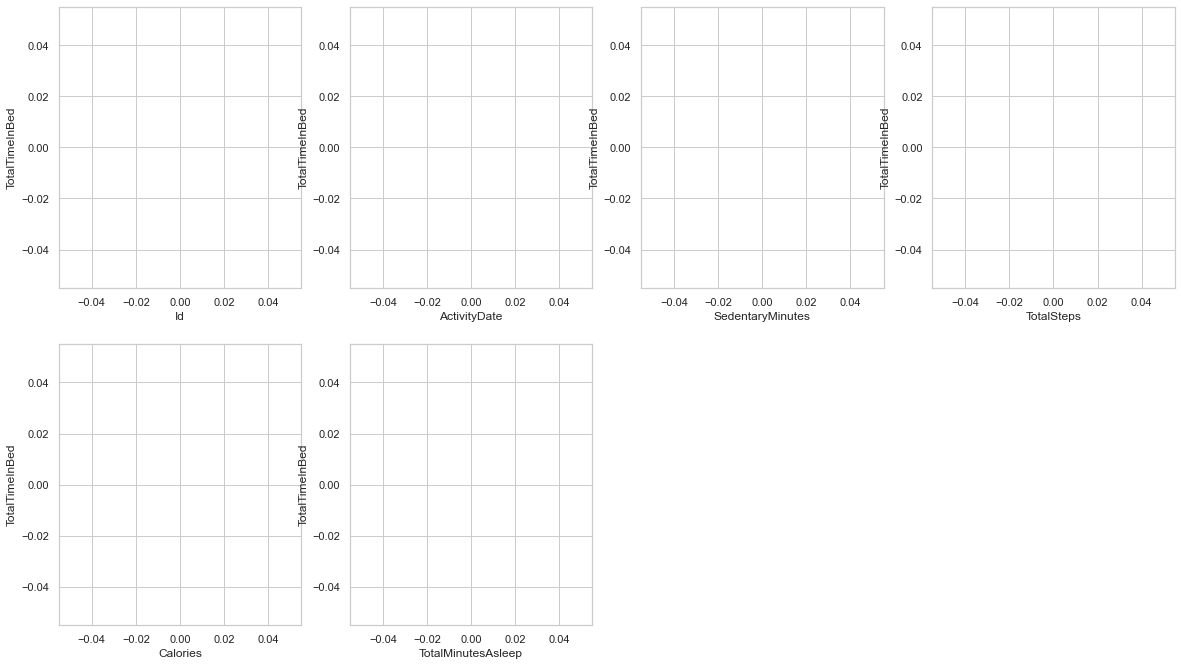

In [45]:
#Machine Learning
column_to_move = fitbit_df.pop("Calories")
fitbit_df.insert(4, "Calories", column_to_move)
print(fitbit_df.columns)

# Define a function to plot the scatterplots of the relationships between
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):
    variables = df.columns
   
    # assume that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,30))
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(fitbit_df,4)

In [ ]:
# Plot the correlations as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fitbit_df.corr(), annot=True, cmap='coolwarm', fmt='.2g')

In [ ]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(fitbit_df.iloc[:,:-1],
                                                              fitbit_df['Calories'],
                                                              test_size=0.2,
                                                              random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp,
                                                      test_size=0.25, random_state=42)

In [ ]:
# scale the data with object range of 0-1
scaler = MinMaxScaler()

scaler.fit_transform(X_train)

scaler.transform(X_valid)
scaler.transform(X_test)

In [ ]:
def scoring(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    print('Mean Squared Error: {:0.4f}.'.format(mse))
    print('R^2 Score = {:0.4f}.'.format(r2))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
   
# Create list of median predictions that has the same length as y_valid
baseline_y = [y_train.median()] * len(y_valid)

# Compute the relevant scores
base_predictions = baseline_y
base_mae = mean_absolute_error(y_valid, base_predictions)
base_mse = mean_squared_error(y_valid, base_predictions)
base_r2 = r2_score(y_valid, base_predictions)
base_errors = abs(base_predictions - y_valid)
base_mape = 100 * np.mean(base_errors / y_valid)
base_accuracy = 100 - base_mape
print('Model Performance')
print('Mean Absolute Error: {:0.4f}.'.format(base_mae))
print('Mean Squared Error: {:0.4f}.'.format(base_mse))
print('R^2 Score = {:0.4f}.'.format(base_r2))
print('Accuracy = {:0.2f}%.'.format(base_accuracy))

In [ ]:
# Define a function that compares the CV perfromance of a set of predetrmined models
def cv_comparison(models, X, y, cv):
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
   
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

In [ ]:
# Set hyperparameters possibilities for tuning Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
rf_max_depth.append(None)
rf_max_features = ['auto', 'sqrt', 'log2']
rf_criterion = ['mse', 'mae']
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]
rf_min_impurity_decrease = [0.0, 0.05, 0.1]
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_grid

In [ ]:
# Tune the Random Forest Model
rf_base = rf_sk()
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid,
                               n_iter = 200, cv = 3, verbose = 2, random_state = 42,
                               n_jobs = -1)

rf_random.fit(X_train_temp, y_train_temp)

rf_random.best_estimator_

In [50]:
#fitbit_df.to_csv('C://Users/Test/Downloadst/fitbit_df.csv', index=False)

CSV_PATH = "C://Users/Test/Downloads/fitbit_df.csv"
APP_NAME = "Random Forest"# U can choose the APP name
SPARK_URL = "local[*]"
RANDOM_SEED = 13579
TRAINING_DATA_RATIO = 0.7
RF_NUM_TREES = 3
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

spark = SparkSession.builder \
    .appName(APP_NAME) \
    .master(SPARK_URL) \
    .getOrCreate()

df = spark.read \
    .options(header = "true", inferschema = "true") \
    .csv(CSV_PATH)

print("Total number of rows: %d" % df.count())

df.printSchema()

df.show()

Total number of rows: 413
root
 |-- SedentaryMinutes: integer (nullable = true)
 |-- TotalSteps: integer (nullable = true)
 |-- TotalMinutesAsleep: integer (nullable = true)
 |-- TotalTimeInBed: integer (nullable = true)
 |-- Calories: integer (nullable = true)

+----------------+----------+------------------+--------------+--------+
|SedentaryMinutes|TotalSteps|TotalMinutesAsleep|TotalTimeInBed|Calories|
+----------------+----------+------------------+--------------+--------+
|             728|     13162|               327|           346|    1985|
|             776|     10735|               384|           407|    1797|
|             726|      9762|               412|           442|    1745|
|             773|     12669|               340|           367|    1863|
|             539|      9705|               700|           712|    1728|
|             775|     15506|               304|           320|    2035|
|             818|     10544|               360|           377|    1786|
|      

In [51]:
# create features
featureCols = ['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed']
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
df = assembler.transform(df)
spark_df = df.select(['features', 'Calories'])

spark_df.show()
spark_df.printSchema()

+--------------------+--------+
|            features|Calories|
+--------------------+--------+
|[728.0,13162.0,32...|    1985|
|[776.0,10735.0,38...|    1797|
|[726.0,9762.0,412...|    1745|
|[773.0,12669.0,34...|    1863|
|[539.0,9705.0,700...|    1728|
|[775.0,15506.0,30...|    2035|
|[818.0,10544.0,36...|    1786|
|[838.0,9819.0,325...|    1775|
|[732.0,14371.0,36...|    1949|
|[709.0,10039.0,43...|    1788|
|[814.0,15355.0,27...|    2013|
|[833.0,13755.0,24...|    1970|
|[782.0,13154.0,36...|    1898|
|[815.0,11181.0,34...|    1837|
|[712.0,14673.0,40...|    1947|
|[730.0,10602.0,36...|    1820|
|[798.0,14727.0,27...|    2004|
|[816.0,15103.0,27...|    1990|
|[857.0,14070.0,24...|    1959|
|[754.0,12159.0,33...|    1896|
+--------------------+--------+
only showing top 20 rows

root
 |-- features: vector (nullable = true)
 |-- Calories: integer (nullable = true)



In [52]:
train, test = spark_df.randomSplit([0.8, 0.2], seed = 42)
print("Number of training set rows: %d" % train.count())
print("Number of test set rows: %d" % test.count())

Number of training set rows: 354
Number of test set rows: 59


In [53]:
rf = rf_sp(featuresCol="features", labelCol='Calories')

model = rf.fit(train)

predictions = model.transform(test)

predictions.select("prediction", "Calories", "features").show(5)

preds = predictions.select('prediction').toPandas()['prediction']
test_labels = predictions.select('Calories').toPandas()['Calories']

errors = abs(preds - test_labels)
mape = 100 * np.mean(errors / test_labels)
accuracy = round(100 - mape, 4)
print(f'Accuracy = {accuracy} %')

+------------------+--------+--------------------+
|        prediction|Calories|            features|
+------------------+--------+--------------------+
|1681.3416424791478|    1248|[125.0,4477.0,492...|
|1061.9759712509713|    1240|[241.0,2752.0,404...|
| 2341.857322839639|    1364|[330.0,8891.0,456...|
|2379.0659337665666|    2606|[425.0,11135.0,46...|
| 2434.780601923442|    2469|[456.0,7336.0,498...|
+------------------+--------+--------------------+
only showing top 5 rows

Accuracy = 77.2448 %
